In [6]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [7]:
%matplotlib inline

In [8]:
from relaxed.plot_defaults import *

In [9]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split



In [10]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_an_from_am, get_lam, get_ma, get_gradient, get_fractional_tdyn

# Data

In [11]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')

# get ma 
ma, keep1 = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# remove nan's from am
lam, keep2 = get_lam(am)

ma = ma[keep1 & keep2] # remove NaNs from m(a) before taking any derivatives. 
print(ma.shape)
assert np.sum(np.isnan(ma))==0

(19613, 171)


Text(0.5, 0, '\\rm index')

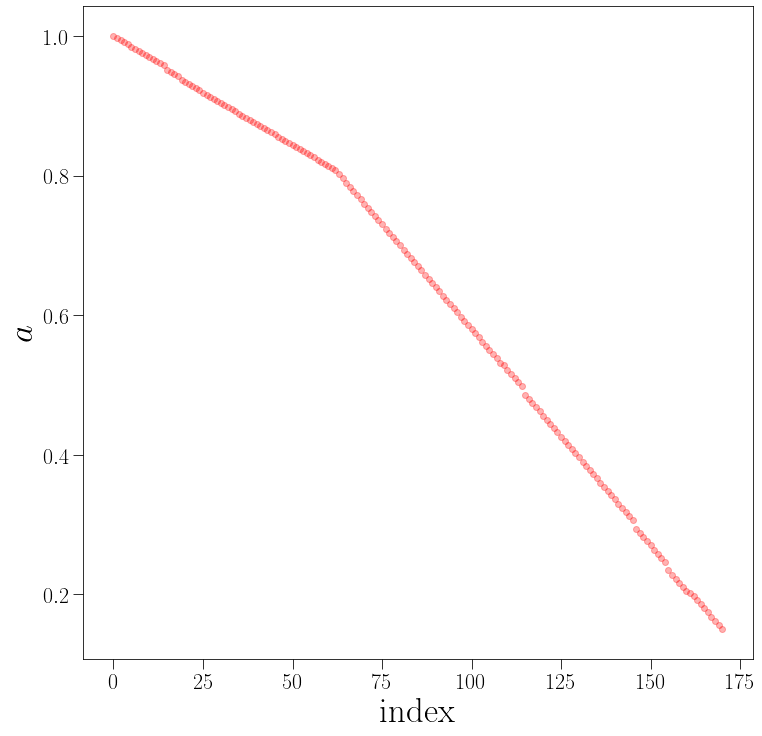

In [30]:
plt.figure(figsize=(12, 12))
plt.plot(scales, 'ro', alpha=0.3)
plt.ylabel(r"$a$", size=35)
plt.xlabel(r"\rm index", size=35)
# notice change in spacing below

# Calculate gradients

## numpy

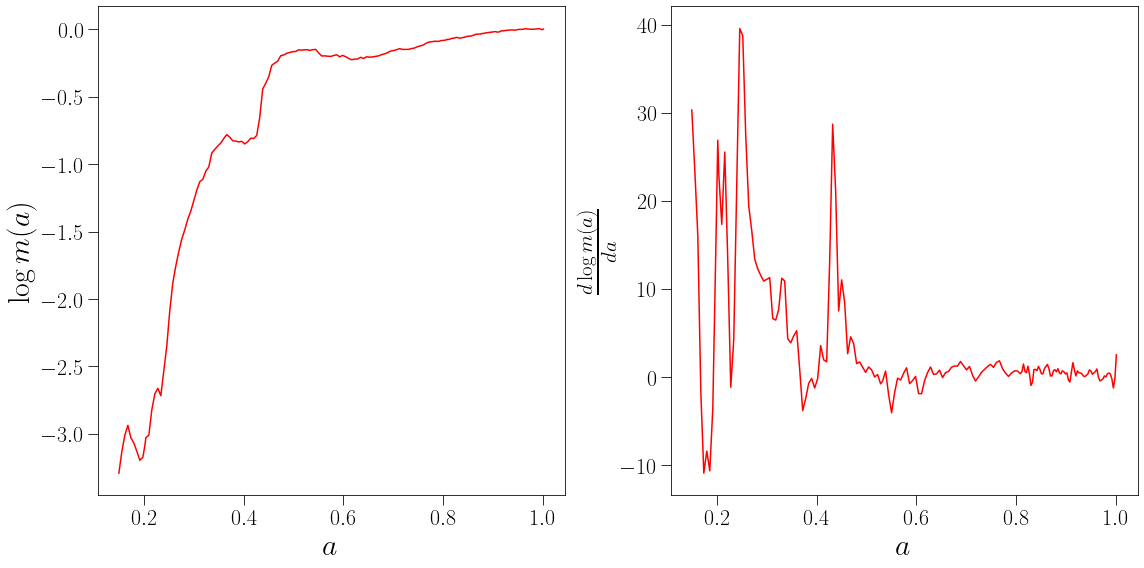

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
idx = 0
x = scales
grad = np.gradient(np.log(ma[idx, :]), x, edge_order=2)
ax1.plot(x, np.log(ma[idx, :]), 'r-')
ax2.plot(x, grad, 'r-')

ax1.set_xlabel(r"$a$", size=30)
ax2.set_xlabel(r"$a$", size=30)

ax1.set_ylabel(r"$\log m(a)$", size=30)
ax2.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
plt.tight_layout()

## vary k 

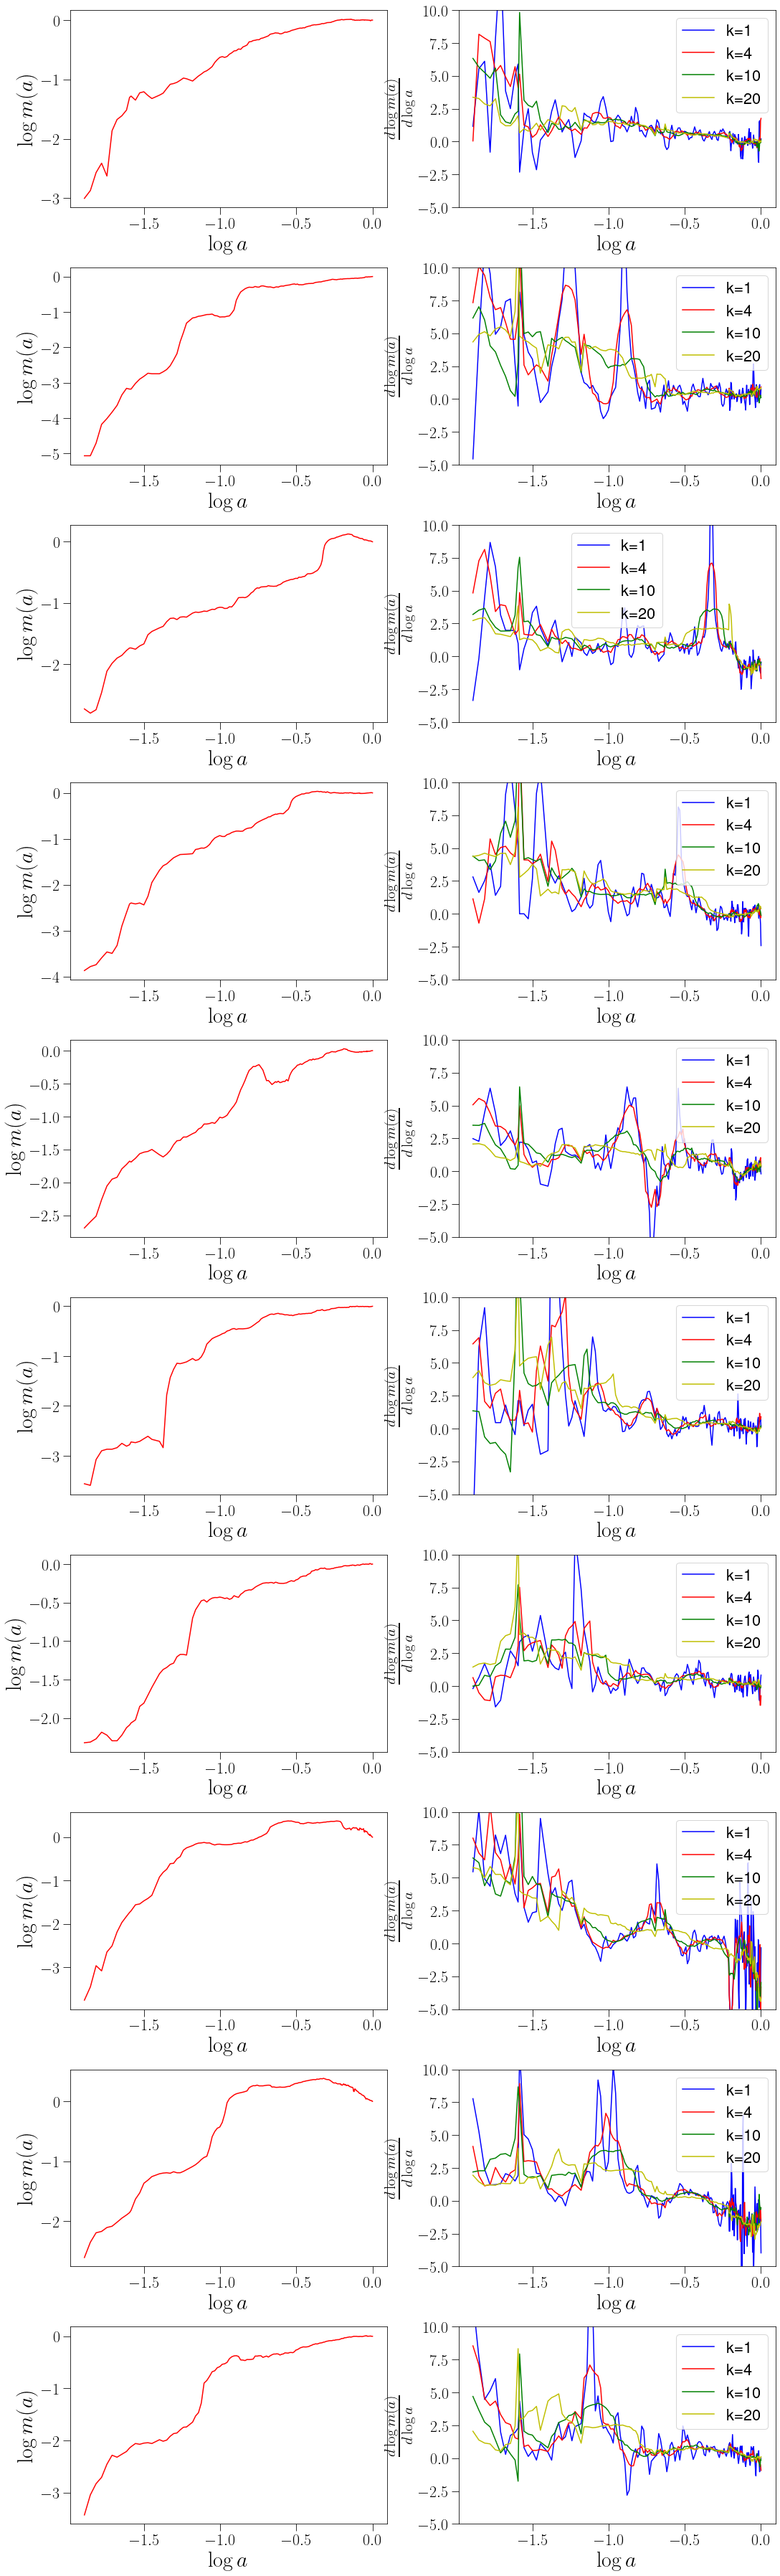

In [32]:
fig, axes = plt.subplots(10, 2, figsize=(15, 50))
indices = np.random.randint(0, len(ma), 10)
ks = [1, 4, 10, 20]
colors = ['b', 'r', 'g', 'y', 'm']
x = np.log(scales)

for i, idx in enumerate(indices): 
    ax1, ax2 = axes[i, :]
    ax1.plot(x, np.log(ma[idx, :]), 'r-')
    
    for c,k in zip(colors, ks): 
        grad = get_gradient(np.log(ma[[idx], :]), x, k=k)
        ax2.plot(x, grad[0], f'{c}-', label=f"k={k}")


    ax2.set_ylim(-5, 10)
    ax1.set_xlabel(r"$\log a$", size=30)
    ax2.set_xlabel(r"$\log a$", size=30)


    ax1.set_ylabel(r"$\log m(a)$", size=30)
    ax2.set_ylabel(r"$\frac{d\log m(a)}{d \log a}$", size=30)
    ax2.legend(loc='best')
plt.tight_layout()

## Fix k, vary accuracy

In [33]:
idx = np.random.randint(len(ma))

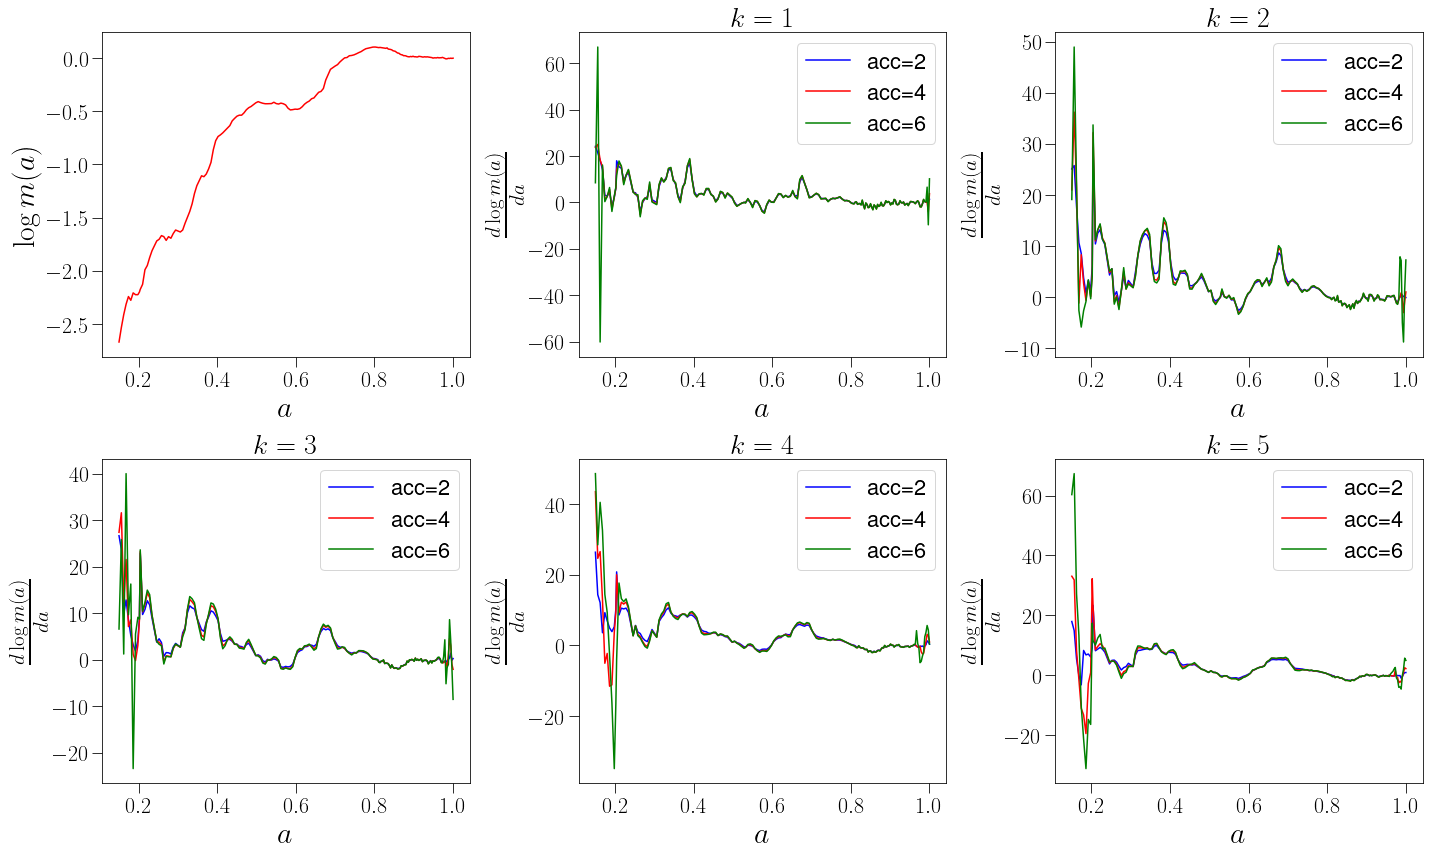

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
ax1 = axes[0]
axs = axes[1:]
x = scales
ks = [1,2,3,4,5]
accs = [2, 4, 6]
colors = ['b', 'r', 'g']
ax1.plot(x, np.log(ma[idx, :]), 'r-')
for k, ax in zip(ks, axs): 
    for c, acc in zip(colors, accs): 
        grad = get_gradient(np.log(ma[[idx], :]), x, k=k, acc=acc)
        ax.plot(x, grad[0], f'{c}-', label=f"acc={acc}")
    ax.set_xlabel(r"$a$", size=30)
    ax.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
    ax.legend(loc='best')
    ax.set_title(fr"$k={k}$")
    
ax1.set_xlabel(r"$a$", size=30)
ax1.set_ylabel(r"$\log m(a)$", size=30)
plt.tight_layout()

# Correlation between gradients and cvir, xoff, t/u

In [36]:
names = ['m11', 'm12']
params = ['cvir', 'x0', 't/|u|']
latex_params = ['c_{\\rm vir}', 'x_{\\rm off}', 't/|u|']
colors = ['r','b', 'g']
markers = np.array(['.', 'x'])

/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:194: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1
/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:194: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1
/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:194: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1


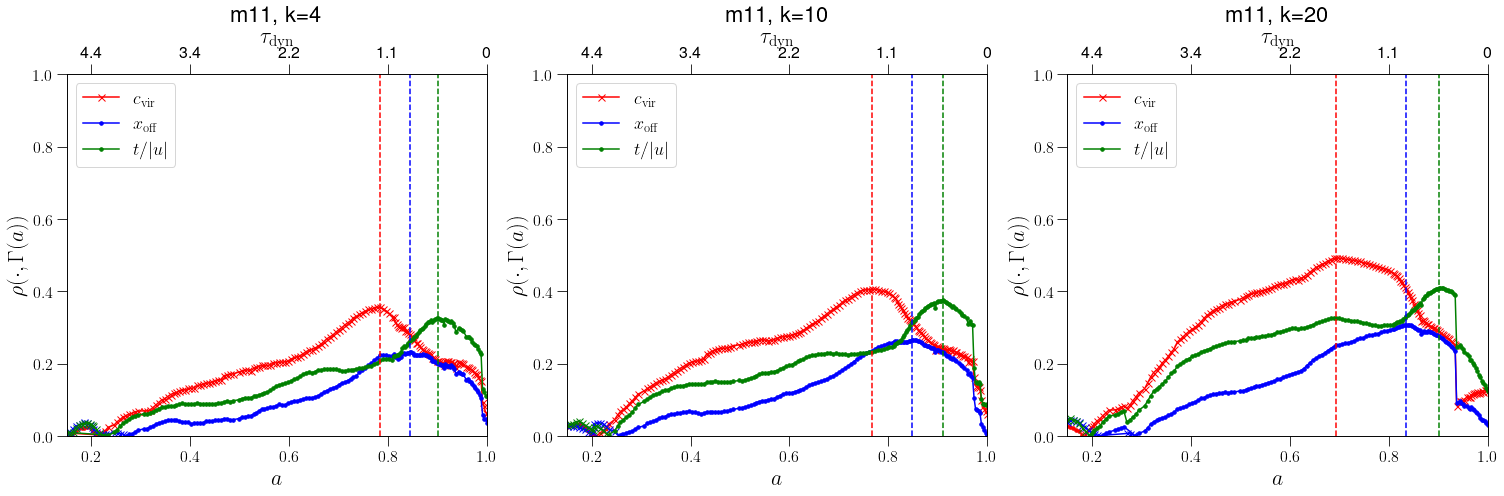

In [43]:
ks = [4, 10, 20]
fig, axes = plt.subplots(1, len(ks), figsize=(len(ks)*7, 7))
axes = axes.flatten()
for p, k in enumerate(ks):
    name = 'm11'
    hcat, indices, scales = setup(name, path='../../../output/30k')
    ma, keep1 = get_ma(hcat.cat, indices)  
    ma = ma[keep1]
    cat = hcat.cat[keep1]
    ax = axes[p]
    max_scales = [0.]*len(params)
    tdyn = np.mean(cat['tdyn']) / 10**9 #Gyr which astropy also returns by default
    grads = get_gradient(np.log(ma), np.log(scales), k=k, acc=2)

    for j, param in enumerate(params):
        latex_param = latex_params[j]
        color = colors[j]
        param_values = cat[param]

        # get correlations
        corrs = []
        for s in range(len(scales)):
            corrs.append(stats.spearmanr(param_values, grads[:,s], nan_policy="omit")[0])
        corrs = np.array(corrs)

        pos = corrs > 0 
        neg = ~pos
        corrs = abs(corrs)

        # plot positive corr and negative corr with different markers. 
        if sum(pos) > 0:
            label = f'${latex_param}$' if sum(pos) > sum(neg) else None
            ax.plot(scales[pos], corrs[pos], color=color, marker=markers[0], label=label, markersize=7)

        if sum(neg) > 0:
            label = f'${latex_param}$' if sum(pos) < sum(neg) else None
            ax.plot(scales[neg], corrs[neg], color=color, marker=markers[1], label=label, markersize=7)

        max_scales[j] = scales[np.nanargmax(abs(corrs))]


    # draw a vertical line at max scales
    for j, s in enumerate(max_scales):
        color = colors[j]
        ax.axvline(s, linestyle='--', color=color)


    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 1.0)
    ax.set_title(f"{name}, k={k}", size=22)
    ax.set_ylabel(f"$\\rho(\\cdot, \\Gamma(a))$", size=22)
    ax.set_xlabel(f"$a$", size=22)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # add additional x-axis with tydn fractional scale
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())

    fractional_tdyn = get_fractional_tdyn(ax.get_xticks(), tdyn, sim_name='Bolshoi')
    fractional_tdyn = np.array([f'{x:.2g}' for x in fractional_tdyn])
    ax2.set_xticklabels(fractional_tdyn, size=16)
    ax2.set_xlabel("$\\tau_{\\rm dyn}$", size=22)

    ax.legend(loc='best', prop={'size': 18})

    ax.set_xlim(0.15, 1)
    ax2.set_xlim(0.15 , 1)
plt.tight_layout()
plt.show()

## focus on one bin correlations

In [ ]:
ks = [4, 10, 20]
fig, axes = plt.subplots(len(ks), len(names),figsize=(len(names)*7,7*len(ks)))
for p, k in enumerate(ks):
    for i, name in enumerate(names):
        hcat, indices, scales = setup(name)
        
        ma = get_ma(hcat.cat, indices)
        ax = axes[p, i]
        max_scales = [0.]*len(params)
        tdyn = np.mean(hcat.cat['tdyn']) / 10**9 #Gyr which astropy also returns by default

        for j, param in enumerate(params):
            latex_param = latex_params[j]
            color = colors[j]
            param_values = hcat.cat[param]
            grads = get_gradient(np.log(ma), scales, k=k, acc=2)

            # get correlations
            corrs = []
            for s in range(len(scales)):
                corrs.append(stats.spearmanr(param_values, grads[:,s], nan_policy="omit")[0])
            corrs = np.array(corrs)

            pos = corrs > 0 
            neg = ~pos
            corrs = abs(corrs)

            # plot positive corr and negative corr with different markers. 
            if sum(pos) > 0:
                label = f'${latex_param}$' if sum(pos) > sum(neg) else None
                ax.plot(scales[pos], corrs[pos], color=color, marker=markers[0], label=label, markersize=7)

            if sum(neg) > 0:
                label = f'${latex_param}$' if sum(pos) < sum(neg) else None
                ax.plot(scales[neg], corrs[neg], color=color, marker=markers[1], label=label, markersize=7)

            max_scales[j] = scales[np.nanargmax(abs(corrs))]


        # draw a vertical line at max scales
        for j, s in enumerate(max_scales):
            color = colors[j]
            ax.axvline(s, linestyle='--', color=color)


        ax.set_ylim(0, 1.0)
        ax.set_xlim(0, 1.0)
        ax.set_title(f"{name}, k={k}", size=22)
        ax.set_ylabel(f"$\\rho(\\cdot, \\Gamma(a))$", size=22)
        ax.set_xlabel(f"$a$", size=22)
        ax.tick_params(axis='both', which='major', labelsize=16)

        # add additional x-axis with tydn fractional scale
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(ax.get_xticks())

        fractional_tdyn = get_fractional_tdyn(ax.get_xticks(), tdyn, sim_name='Bolshoi')
        fractional_tdyn = np.array([f'{x:.2g}' for x in fractional_tdyn])
        ax2.set_xticklabels(fractional_tdyn, size=16)
        ax2.set_xlabel("$\\tau_{\\rm dyn}$", size=22)

        ax.legend(loc='best', prop={'size': 18})

        ax.set_xlim(0.15, 1)
        ax2.set_xlim(0.15 , 1)
plt.tight_layout()
plt.show()